# fashion_mnist_example
fashion mnist dataset has 10 classes in 4 varieties:  
- Tops: T-shirt/top, Pullover, Dress, Coat, Shirt
- Bottoms: Trouser
- Shoes: Sandal, Sneaker, Ankle boot
- Bags: Bag

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf

from models.cnn import vgg8
from src.utils import plot_confusion_matrix, plot_learning_history
from src.keras_callback import get_callback
from src.keras_utils import get_features

tf.random.set_seed(1)
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",  "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [2]:
# load fashion mnist dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# shape of dataset
print(f"{X_train.shape=}\n {y_train.shape=}\n {X_test.shape=}\n {y_test.shape=}")

X_train.shape=(60000, 28, 28)
 y_train.shape=(60000,)
 X_test.shape=(10000, 28, 28)
 y_test.shape=(10000,)


In [3]:
# Normalize image data
X_train = X_train / 255.0
X_test = X_test / 255.0

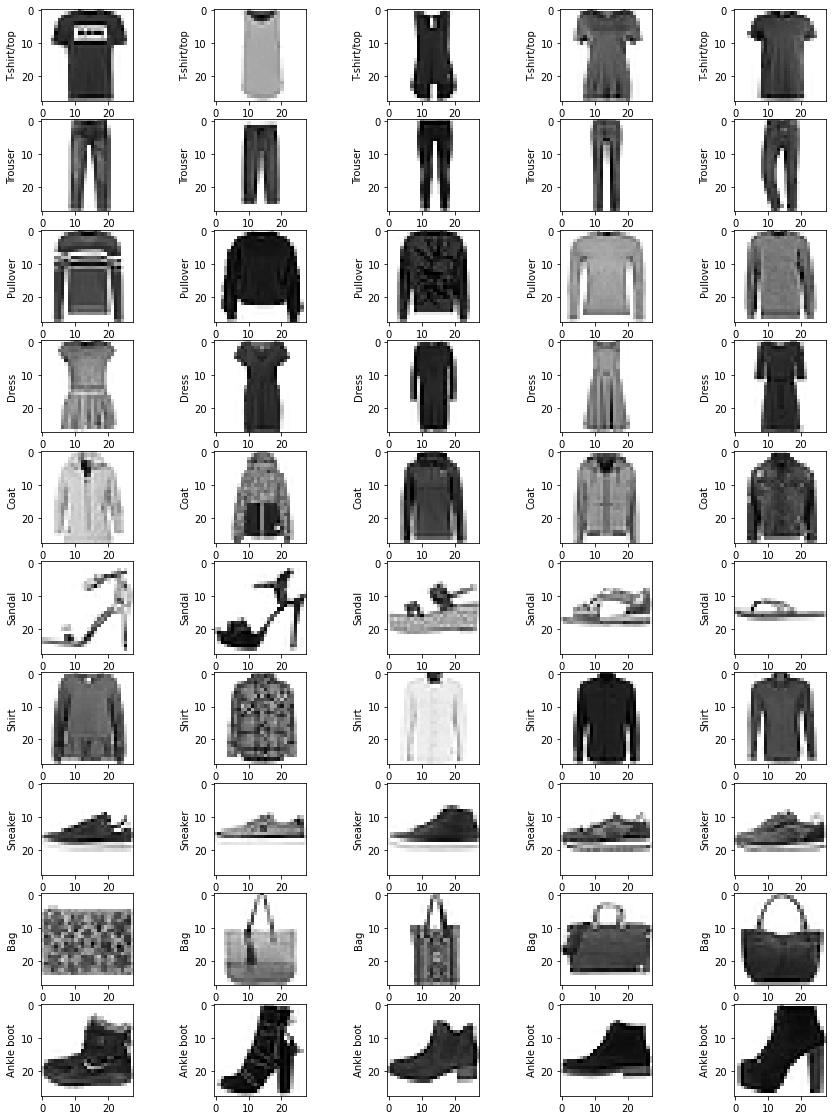

In [4]:
# Plot some images of each class
f, ax = plt.subplots(10, 5, figsize=(15, 20))
for cls in range(10):
    imgs = X_train[np.where(y_train == cls)][:5]  # Pick up 5 images
    for j in range(5):
        ax[cls, j].imshow(imgs[j], cmap=plt.cm.binary)
        ax[cls, j].set_ylabel(class_names[cls])

plt.show()

In [4]:
# prepare train / validation / test data
X_train = X_train.reshape(*X_train.shape, 1)
y_train = tf.keras.utils.to_categorical(y_train, 10)
X_test= X_test.reshape(*X_test.shape, 1)
y_test = tf.keras.utils.to_categorical(y_test, 10)

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=71, shuffle=True, stratify=y_train)

In [5]:
model = vgg8()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
callbacks = get_callback(patience=5, path_chpt="models/vgg8_fashion_mnist.h5")
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 16)       

In [6]:
fit = model.fit(
    X_tr, y_tr,
    epochs=1000,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=0
    )

Epoch 00021: early stopping


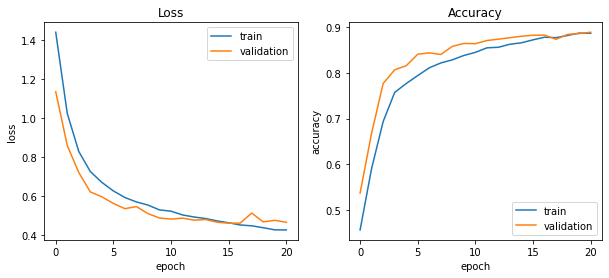

In [7]:
plot_learning_history(fit)

In [8]:
# load best model
model = tf.keras.models.load_model("models/vgg8_fashion_mnist.h5")

# evaluate model
loss_train, acc_train = model.evaluate(X_tr,  y_tr, verbose=0)
loss_valid, acc_valid = model.evaluate(X_val,  y_val, verbose=0)
loss_test, acc_test = model.evaluate(X_test,  y_test, verbose=0)
print(f"train loss={loss_train:.4f}\t accuracy={acc_train:.4f}")
print(f"validation loss={loss_valid:.4f}\t accuracy={acc_valid:.4f}")
print(f"test loss={loss_test:.4f}\t accuracy={acc_test:.4f}")

train loss=0.3342	 accuracy=0.9158
validation loss=0.4603	 accuracy=0.8819
test loss=0.4661	 accuracy=0.8802


### 混合行列
- T-shirt/top, Pullover, CoatからShirtへの誤分類が多い (似たクラス)
- SneakerからAnkle bootへの誤分類が多い (似たクラス)
- Trouser(ズボン)、Sandal, Sneaker, Bag、Ankle bootは他クラスへん誤分類が少ない (Sandal, Sneaker, Ankle bootは見た目が異なる)

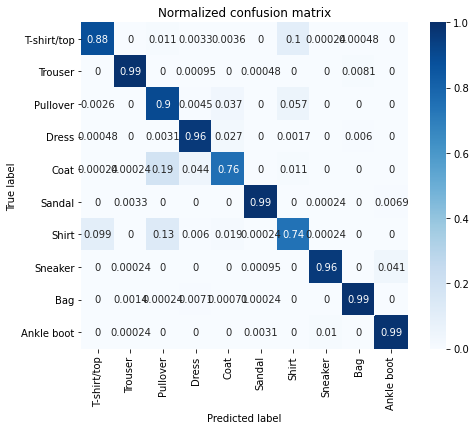

In [9]:
# train confision matrix
plot_confusion_matrix(y_tr.argmax(axis=1), model.predict(X_tr).argmax(axis=1), labels=class_names, figsize=(8, 6))

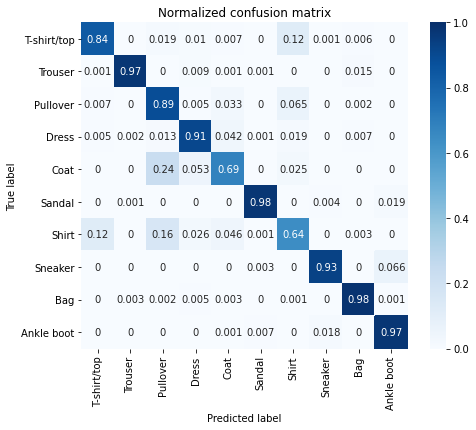

In [10]:
# test confision matrix
plot_confusion_matrix(y_test.argmax(axis=1), model.predict(X_test).argmax(axis=1), labels=class_names, figsize=(8, 6))

### Plot embedding
- 誤分類が多いクラスは近くにある = 似たクラスは近くにある
- 線形にseparativeな形にプロットされている (discriminativeではない)

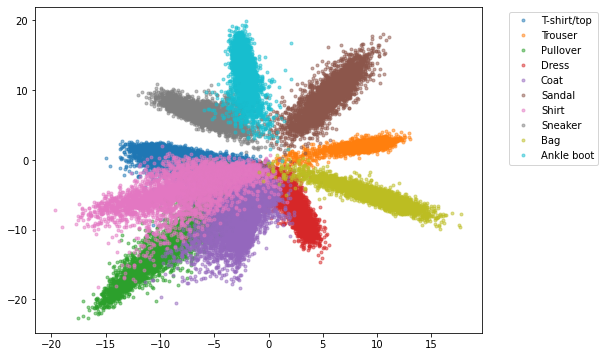

In [11]:
# plot fully-connected output - train
feat_train = get_features(model=model, X=X_tr)
fig = plt.figure(figsize=(8, 6))
for cls in range(10):
    plt.plot(feat_train[y_tr.argmax(axis=-1)==cls, 0], feat_train[y_tr.argmax(axis=-1)==cls, 1], '.', alpha=0.5, label=class_names[cls])

plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

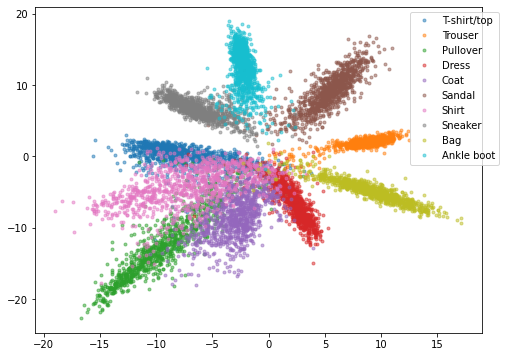

In [12]:
# plot fully-connected output - test
feat_test = get_features(model=model, X=X_test)
fig = plt.figure(figsize=(8, 6))
for cls in range(10):
    plt.plot(feat_test[y_test.argmax(axis=-1)==cls, 0], feat_test[y_test.argmax(axis=-1)==cls, 1], '.', alpha=0.5, label=class_names[cls])

plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

### Plot weights
- 出力(XW)の方向に一致

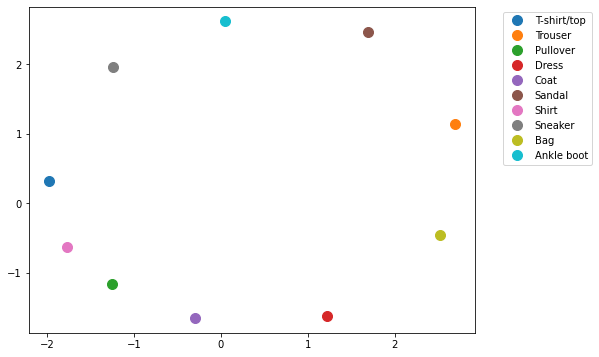

In [32]:
# plot fully-connected weight
wgt = model.layers[-1].get_weights()[0]
fig = plt.figure(figsize=(8, 6))
for cls in range(10):
    plt.plot(wgt[0, cls], wgt[1, cls], '.', markersize=20, label=class_names[cls])

plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()